## The current project takes IBM stock values between... 




Introduction:
The goal of this project is to develop a stock trading strategy using the predictions obtained from a learning algorithm. The developed learner predicts the change in stock price over the next five trading days. 

DatetimeIndex(['2007-11-30', '2007-12-01', '2007-12-02', '2007-12-03',
               '2007-12-04', '2007-12-05', '2007-12-06', '2007-12-07',
               '2007-12-08', '2007-12-09',
               ...
               '2012-01-22', '2012-01-23', '2012-01-24', '2012-01-25',
               '2012-01-26', '2012-01-27', '2012-01-28', '2012-01-29',
               '2012-01-30', '2012-01-31'],
              dtype='datetime64[ns]', length=1524, freq='D')
                  IBM
Date                 
2007-11-30  76.883553
2007-12-03  77.358650
2007-12-04  77.943428
2007-12-05  79.061798
2007-12-06  80.187523


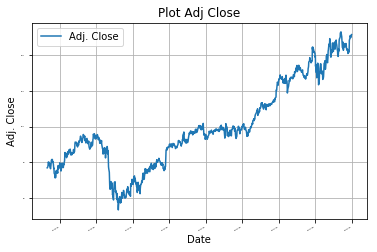

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime as dt
import pandas as pd

sd = dt.datetime(2007,11,30) 
ed = dt.datetime(2012,1,31)
syms=['IBM']
dates = pd.date_range(sd, ed)
print(dates)
dfAdj = pd.DataFrame(index=dates)
dfAdj = pd.read_csv(syms[0] + '.csv', index_col="Date", parse_dates=True, usecols=['Date', 'Adj Close'],na_values=['NaN'])    # Reading files from the data/xxx.csv. Also replacing missing values with NANs
dfAdj.head()
dfAdj = dfAdj.rename(columns={'Adj Close': syms[0]})     # Renaming the Adj Close column to the symbol
dfAdj.fillna(method='ffill', inplace=True)
dfAdj.fillna(method='bfill', inplace=True)

dfAdj = dfAdj.dropna()
print(dfAdj.head())


pl1 = dfAdj.plot(y='IBM',label='Adj. Close',title='Plot Adj Close',fontsize=2)
plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.grid()
plt.show()


Computing Bolinger Bands

In [76]:
bolBand=pd.DataFrame()
wndwSize=20
bolBand['MVA_20']=dfAdj[syms[0]].rolling(window=wndwSize).mean()
bolBand['StdA_20']=bolBand['MVA_20']+2*dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand['StdB_20']=bolBand['MVA_20']-2*dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand['Std_20']=dfAdj[syms[0]].rolling(window=wndwSize).std()
#print(bolBand['Date'])
bolBand[syms[0]]=dfAdj[syms[0]]
mNSize=10;
mNSize1=5;
mNSize2=20;
bolBand['Mom_10']=np.nan
bolBand['Mom_05']=np.nan
bolBand['Mom_20']=np.nan
bolBand['Mom_01']=np.nan
bolBand=bolBand.reset_index()
bolBand['MVA Norm']=(bolBand[syms[0]]-bolBand['MVA_20'])/(2*bolBand['Std_20'])
print(bolBand['MVA Norm'].min())
print(bolBand['MVA Norm'].max())


-1.601407170697803
1.6693932709115717


Computing Momentum

In [77]:

for x in range(mNSize,bolBand['IBM'].count()):
    bolBand.at[x,'Mom_10']= (bolBand.loc[x,[syms[0]]])/ (bolBand.loc[x-mNSize,[syms[0]]])-1
    
for x in range(mNSize1,bolBand['IBM'].count()):
    bolBand.at[x,'Mom_05']= (bolBand.loc[x,[syms[0]]])/ (bolBand.loc[x-mNSize1,[syms[0]]])-1

for x in range(mNSize2,bolBand['IBM'].count()):
    bolBand.at[x,'Mom_20']= (bolBand.loc[x,[syms[0]]])/ (bolBand.loc[x-mNSize2,[syms[0]]])-1
    
for x in range(mNSize2,bolBand['IBM'].count()):
    bolBand.at[x,'Mom_01']= (bolBand.loc[x,[syms[0]]])/ (bolBand.loc[x-1,[syms[0]]])-1


Computing Ys

In [78]:
daysAhead=5;
bolBand['Y_5']=np.nan
for x in range(mNSize,bolBand['IBM'].count()-daysAhead-1):
    bolBand.at[x,'Y_5']= (bolBand.loc[x+daysAhead,[syms[0]]])/ (bolBand.loc[x,[syms[0]]])-1
    
    


Plots

-1.5057341223535745
1.4568728476456088


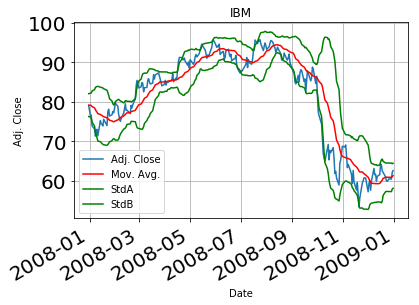

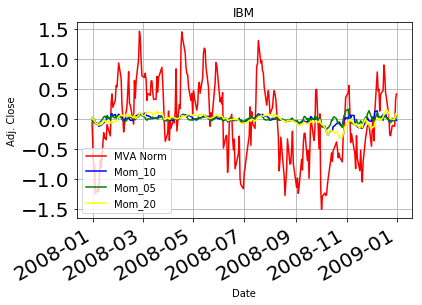

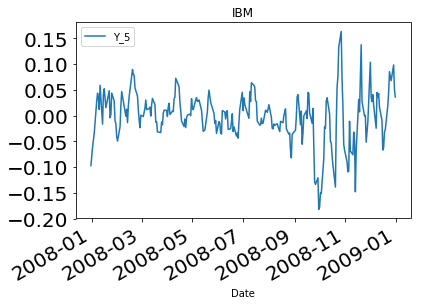

In [79]:

bolBand=bolBand.set_index('Date')
mastData=bolBand
# We are reducing bolBand for visualizationin graphs
bolBand=bolBand.loc[dt.datetime(2007,12,31):dt.datetime(2008,12,31)]
print(bolBand['MVA Norm'].min())
print(bolBand['MVA Norm'].max())
ax=plt.figure(1)
ax=plt.gca()
bolBand.plot(y=syms[0],label='Adj. Close',title=syms[0],fontsize=20,ax=ax)
bolBand.plot(y='MVA_20',label='Mov. Avg.',title=syms[0],fontsize=20,color='red',ax=ax)
bolBand.plot(y='StdA_20',label='StdA',title=syms[0],fontsize=20,color='green',ax=ax)
bolBand.plot(y='StdB_20',label='StdB',title=syms[0],fontsize=20,color='green',ax=ax)



plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.grid()

ax1=plt.figure(2)
ax1=plt.gca()


bolBand.plot(y='MVA Norm',label='MVA Norm',title=syms[0],fontsize=20,color='red',ax=ax1)
bolBand.plot(y='Mom_10',label='Mom_10',title=syms[0],fontsize=20,color='blue',ax=ax1)
bolBand.plot(y='Mom_05',label='Mom_05',title=syms[0],fontsize=20,color='green',ax=ax1)
bolBand.plot(y='Mom_20',label='Mom_20',title=syms[0],fontsize=20,color='yellow',ax=ax1)




plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.grid()



ax2=plt.figure()
ax2=plt.gca()
#bolBand.plot(y='IBM',label='Y_5',title=syms[0],fontsize=20,ax=ax2)
bolBand.plot(y='Y_5',label='Y_5',title=syms[0],fontsize=20,ax=ax2)

Separating Data

In [80]:
dfTraining=mastData.loc[dt.datetime(2007,12,31):dt.datetime(2010,12,31)]
print(dfTraining.tail())
dfTraining=dfTraining.reset_index()
#dfTrainingX=dfTraining[['MVA Norm','Mom_01','Mom_20','Mom_10','Mom_05']]
dfTrainingX=dfTraining[['MVA Norm','Mom_05']]
dfTrainingY=dfTraining['Y_5']
print(dfTraining.describe())


dfTesting=mastData.loc[dt.datetime(2010,12,31):dt.datetime(2011,12,31)]
print(dfTesting.tail())
dfTesting=dfTesting.reset_index()
#dfTestingX=dfTesting[['MVA Norm','Mom_01','Mom_20','Mom_10','Mom_05']]
dfTestingX=dfTesting[['MVA Norm','Mom_05']]
dfTestingY=dfTesting['Y_5']
print(dfTrainingX.head())
print(dfTrainingY.head())
print(dfTestingX.tail())
print(dfTestingY.tail())

print('Training Features Shape:', dfTrainingX.shape)
print('Training Labels Shape:', dfTrainingY.shape)
print('Testing Features Shape:', dfTestingX.shape)
print('Training Labels Shape:', dfTestingY.shape)


                MVA_20     StdA_20     StdB_20    Std_20         IBM  \
Date                                                                   
2010-12-27  111.881084  113.521975  110.240192  0.820446  112.366997   
2010-12-28  111.990096  113.523213  110.456979  0.766558  112.653076   
2010-12-29  112.185697  113.230201  111.141193  0.522252  113.279289   
2010-12-30  112.273061  113.415864  111.130257  0.571402  113.395271   
2010-12-31  112.334137  113.594742  111.073533  0.630302  113.464836   

              Mom_10    Mom_05    Mom_20    Mom_01  MVA Norm       Y_5  
Date                                                                    
2010-12-27  0.003590  0.002345  0.010007 -0.003770  0.296128  0.014724  
2010-12-28  0.009912  0.008304  0.019736  0.002546  0.432439  0.013245  
2010-12-29  0.004800  0.005352  0.035770  0.005559  1.046996  0.003617  
2010-12-30  0.013474  0.004933  0.015650  0.001024  0.981980  0.013568  
2010-12-31  0.015289  0.005963  0.010883  0.000613  0.896

Train Model

-0.000663206304028377
The coefficient for MVA Norm is -0.000663206304028377
The coefficient for Mom_05 is -0.13978154704186116
The intercept for our model is 0.003934706624580091
Training MSE is 0.03713832726787301
Testing MSE is 0.030087837140452565
   YP_5
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN


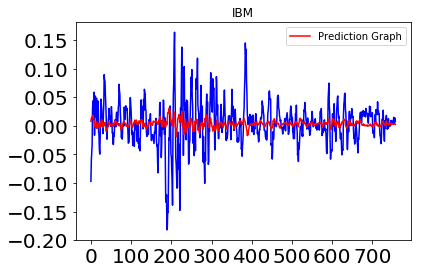

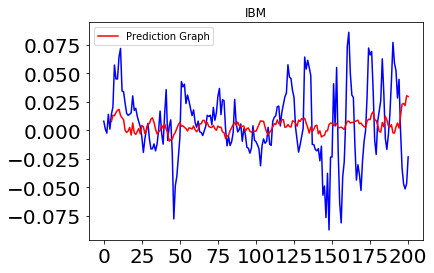

In [81]:
regression_model=LinearRegression()
regression_model.fit(dfTrainingX,dfTrainingY)
print(regression_model.coef_[0])
for idx, col_name in enumerate(dfTrainingX.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))
intercept=regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

regression_model.score(dfTrainingX,dfTrainingY)

from sklearn.metrics import mean_squared_error
y_predict=regression_model.predict(dfTrainingX)
regression_model_mse=mean_squared_error(y_predict,dfTrainingY)
regression_model_mse
import math
print("Training MSE is {}".format(math.sqrt(regression_model_mse)))


dfPredictedY = pd.DataFrame()
dfPredictedY['YP_5']=y_predict

ax4=plt.figure()
ax4=plt.gca()


dfTrainingY.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax4)
dfPredictedY.plot(y='YP_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax4)



new_predict=regression_model.predict(dfTestingX)
regression_model_mse=mean_squared_error(new_predict,dfTestingY)
regression_model_mse
import math
print("Testing MSE is {}".format(math.sqrt(regression_model_mse)))


dfPredictedY1 = pd.DataFrame()
dfPredictedY1['YP_5']=y_predict

ax3=plt.figure()
ax3=plt.gca()

dfTestingY1=dfTestingY.loc[0:200]
dfPredictedY1=dfPredictedY.loc[0:200]
dfPredictedY1=dfPredictedY1.shift(periods=5)
print(dfPredictedY1.head())
dfTestingY1.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax3)
dfPredictedY1.plot(y='YP_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax3)


Random Forest

Testing MSE is 0.03513574309463537
Mean Absolute Error: 0.03
-20.484564803722847
Accuracy 120.48 %.
   YP_5
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN


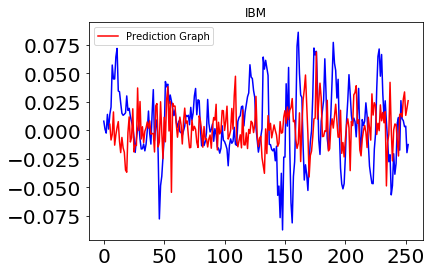

In [83]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(dfTrainingX,dfTrainingY)
predictions=rf.predict(dfTestingX)
regression_model_mse=mean_squared_error(predictions,dfTestingY)
regression_model_mse
import math
print("Testing MSE is {}".format(math.sqrt(regression_model_mse)))
errors = abs(predictions - dfTestingY)
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = 100 * (errors / dfTestingY)

accuracy=100-np.mean(mape)
print(np.mean(mape))
print('Accuracy',round(accuracy,2),'%.')



dfPredictedY2 = pd.DataFrame()
dfPredictedY2['YP_5']=predictions

ax6=plt.figure()
ax6=plt.gca()

dfTestingY2=dfTestingY#.loc[0:200]
dfPredictedY2=dfPredictedY2#.loc[0:200]
dfPredictedY2=dfPredictedY2.shift(periods=5)
print(dfPredictedY2.head())
dfTestingY2.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax6)
dfPredictedY2.plot(y='YP_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax6)